In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sn

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
import matplotlib.cm as cm
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import f_regression
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data

pitches_orig = pd.read_csv('pitches.csv')
at_bat = pd.read_csv('atbats.csv')

prep data for model
---

In [3]:
#right handed at bats
at_bat_right_hand = at_bat.loc[at_bat.stand == 'R']
#only look at pitches where batter is right handed
pitches_orig = pd.merge(pitches_orig, at_bat_right_hand, how = 'inner', right_on = 'ab_id', left_on = 'ab_id')
#only look at pithches that were swung at
pitches_orig = pitches_orig.loc[(pitches_orig.code.isin(['X', 'D', 'E', 'S'])) & (pitches_orig.pitch_type.isin(['FT', 'FF']))]
#binary coding for in play or not after swing
pitches_orig.loc[pitches_orig.code.isin(['X', 'D', 'E']), 'in_play_boolean'] = int(1)
pitches_orig.loc[pitches_orig.code.isin(['S']), 'in_play_boolean'] = int(0)

#create model df with in_play_boolean as response
model_df = pitches_orig[['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'pitch_type','in_play_boolean']]
#dummies
pitch_typed = pd.get_dummies(model_df['pitch_type'])
model_df = pd.concat([model_df, pitch_typed], axis=1)
model_df = model_df.drop(['FT'], axis =1)

EDA
---

In [4]:
print(model_df.loc[model_df.in_play_boolean == 1].shape[0])
print(model_df.loc[model_df.in_play_boolean == 0].shape[0])
print(model_df.loc[model_df.in_play_boolean == 1].shape[0]/model_df.shape[0])
print(model_df.loc[model_df.in_play_boolean == 0].shape[0]/model_df.shape[0])

142339
58737
0.707886570252044
0.292113429747956


In [5]:
x = pd.crosstab(model_df.in_play_boolean, model_df.FF)
print(x)
stats.chi2_contingency(x)

FF                   0       1
in_play_boolean               
0.0              10857   47880
1.0              41775  100564


(2539.4250437205733, 0.0, 1, array([[ 15374.51403449,  43362.48596551],
        [ 37257.48596551, 105081.51403449]]))

fit model 
---

In [6]:
features = model_df[['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'FF']]

model_list = []
#loop to look at best subset for each size and fit a model to it
for i in range(1,features.shape[1]+1):    
    #possible features for model
    X = sm.add_constant(features)    
    
    #get features using RFE
    model = LogisticRegression(solver='lbfgs')
    rfe = RFE(model, i)
    fit = rfe.fit(features, model_df['in_play_boolean'])
    
    #only fit model with features from RFE
    X = features[features.columns[fit.support_]]
    X = sm.add_constant(X)
    X_train, X_test, y_train, y_test = train_test_split(X, model_df['in_play_boolean'], test_size=0.3, random_state=0)
    
    #create logistic model for prediction purposes
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    #for pvalues and interpretation
    logit_model = sm.Logit(y_train,X_train)
    result = logit_model.fit()
    
    #add tuple with summary, aic and bic for later comparision
    model_list.append((result.summary2(), result.aic, result.bic, logreg.score(X_test, y_test)))

Optimization terminated successfully.
         Current function value: 0.571260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545795
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545618
  

compare the models
---

In [7]:
[(x[1],x[2],x[3]) for x in model_list]

[(160816.98726980409, 160836.6967935244, 0.7316778011703662),
 (159264.1333561523, 159293.69764173278, 0.731976194817897),
 (159161.93786092137, 159201.356908362, 0.7317772657195432),
 (157390.79168695753, 157440.06549625835, 0.7364852543805845),
 (154793.51754691146, 154852.64611807244, 0.7418894948858644),
 (154252.51233046528, 154321.49566348642, 0.7446745022628185),
 (154244.5554440481, 154323.3935389294, 0.7445418828639159),
 (154037.38610899376, 154126.0789657352, 0.745006050760075),
 (153664.69814164555, 153763.24576024717, 0.7430499146262619),
 (153616.6854708693, 153725.08785133107, 0.7434477728229697)]

In [8]:
#look at best model
model_list[5]

(<class 'statsmodels.iolib.summary2.Summary'>
 """
                           Results: Logit
 Model:              Logit            Pseudo R-squared: 0.092      
 Dependent Variable: in_play_boolean  AIC:              154252.5123
 Date:               2019-10-13 21:03 BIC:              154321.4957
 No. Observations:   140753           Log-Likelihood:   -77119.    
 Df Model:           6                LL-Null:          -84958.    
 Df Residuals:       140746           LLR p-value:      0.0000     
 Converged:          1.0000           Scale:            1.0000     
 No. Iterations:     6.0000                                        
 ------------------------------------------------------------------
                 Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
 ------------------------------------------------------------------
 const          137.6839   3.9211  35.1137 0.0000 129.9987 145.3691
 px              -0.3645   0.0109 -33.4748 0.0000  -0.3859  -0.3432
 pz              -0.808

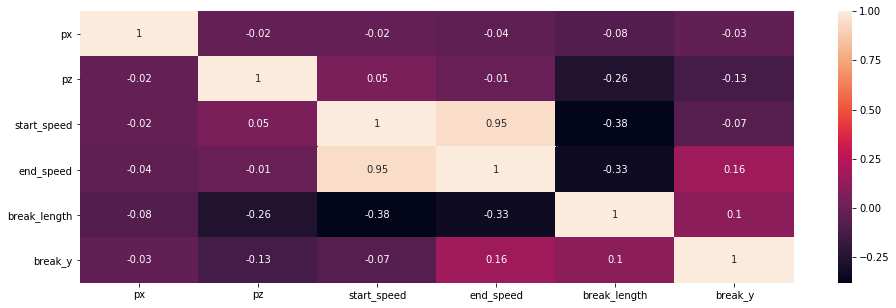

In [9]:
#check for multicollinarity amongst best model
features = model_df[['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'FF']]
correlation_matrix = features[['px', 'pz', 'start_speed', 'end_speed', 'break_length', 'break_y']].corr().round(2)
# annot = True to print the values inside the square
plt.figure(figsize = (16,5))
sn.heatmap(data=correlation_matrix, annot=True)
plt.savefig('corrmatrix.png')

remove end speed and look at model
---

In [10]:
features = model_df[['px', 'pz', 'start_speed', 'break_length', 'break_y']]
X = sm.add_constant(features)

X_train, X_test, y_train, y_test = train_test_split(X, model_df['in_play_boolean'], test_size=0.3, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
    
logit_model = sm.Logit(y_train,X_train)
result = logit_model.fit()
    
print(result.summary2()) 
print(result.aic)
print(result.bic)
print(logreg.score(X_test, y_test))

Optimization terminated successfully.
         Current function value: 0.556941
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.077      
Dependent Variable: in_play_boolean  AIC:              156794.2146
Date:               2019-10-13 21:03 BIC:              156853.3432
No. Observations:   140753           Log-Likelihood:   -78391.    
Df Model:           5                LL-Null:          -84958.    
Df Residuals:       140747           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
const            -6.9759   2.6109  -2.6719 0.0075 -12.0931 -1.8588
px               -0.3968   0.0108 -36.8199 0.0000  -0

In [11]:
np.sum((np.abs(result.resid_pearson) >= 3))/len(result.resid_pearson) * 100

1.7512948214247654

prediction
---

In [12]:
d = {'const': [1], 'px': [np.mean(model_df.px)], 'pz': [np.mean(model_df.pz)], 'start_speed': [np.mean(model_df.start_speed)],
     'break_length': [np.mean(model_df.break_length)], 'break_y': [np.mean(model_df.break_y)]
    }
avgs = pd.DataFrame.from_dict(d)
result.predict(avgs)

0    0.728687
dtype: float64